First, import all of the necessary libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from chord import Chord
from IPython.display import IFrame
from tensorflow.keras.optimizers import Adam
import splitfolders
import itertools
from matplotlib.ticker import MultipleLocator

Now, split the master folder of spectogram data into training, testing, and validation datasets with a specified ratio

In [2]:
splitfolders.ratio('raw', output="img_data", seed=1337, ratio=(0.7, 0.2, 0.1))

Copying files: 4998 files [00:06, 812.81 files/s]


Assign directory names to variables for simplified usage in the future

In [3]:
train_data = 'img_data/train'
val_data = 'img_data/val'
test_data = 'img_data/test'

Sanity check: display an array of classes

In [5]:
num_classes = 10
classes = ['Classical',
 'EDM',
 'Folk',
 'Funk',
 'HipHop',
 'Jazz',
 'Latin',
 'Lofi',
 'Punk',
 'Rock']

classes

['Classical',
 'EDM',
 'Folk',
 'Funk',
 'HipHop',
 'Jazz',
 'Latin',
 'Lofi',
 'Punk',
 'Rock']

Display a sample spectogram from each class

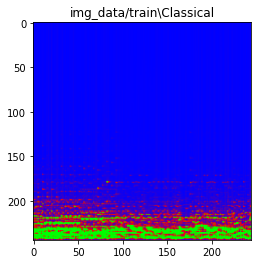

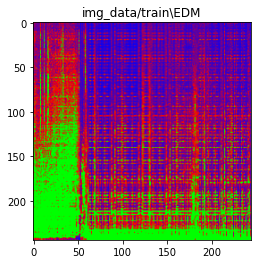

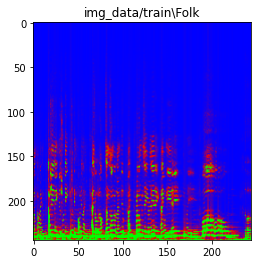

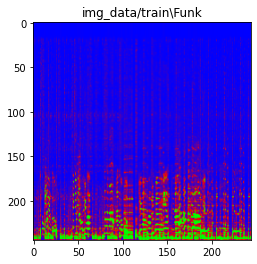

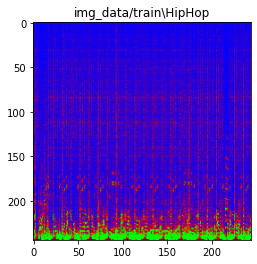

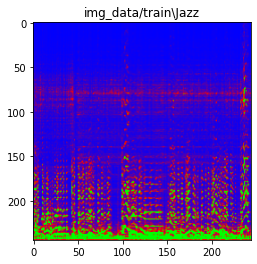

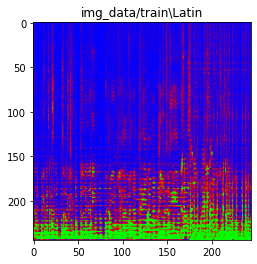

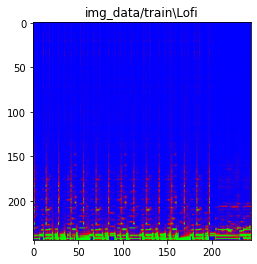

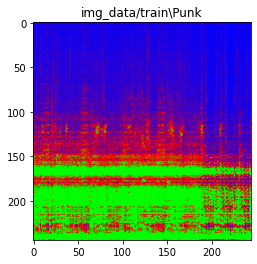

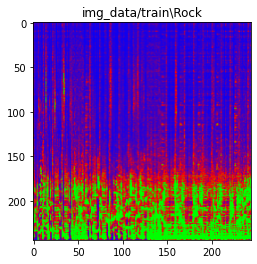

In [6]:
for subdir, dirs, files in os.walk(train_data):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file)
        plt.figure()
        plt.title(subdir)
        plt.imshow(image)
        break

Now, instantiate the VGG16 model loaded with pretrained ImageNet weights as a base for finetuning. Note that we experimented 

In [56]:
vgg = vgg16.VGG16(weights = 'imagenet', include_top = False, pooling = 'max', input_shape = (224, 224, 3))

The VGG16 model is utilized by maintaining the trainability of all of the layers. We experimented with freezing all of the base layers, and only some of the layers in varying proportions. While this reduced the training time drastically, we obtained the best results by allowing all of the layers to be finetuned. The model was adapted for a new set of classes by allowing the base layers to be finetuned and adjusted to new weights and then using max pooling with dropout to take advantage of all of the feature maps, and passing the resulting vector directly into the output layer. We experimented with several approaches, including boostrapping several fully connected layers on top of the pretrained model, but this approach yielded the highest accuracy

In [57]:
x = layers.Dropout(0.3)(vgg.output)
output = layers.Dense(num_classes, activation = 'softmax')(x)
model = Model(inputs = vgg.input, outputs = output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Visualize the layers of the model

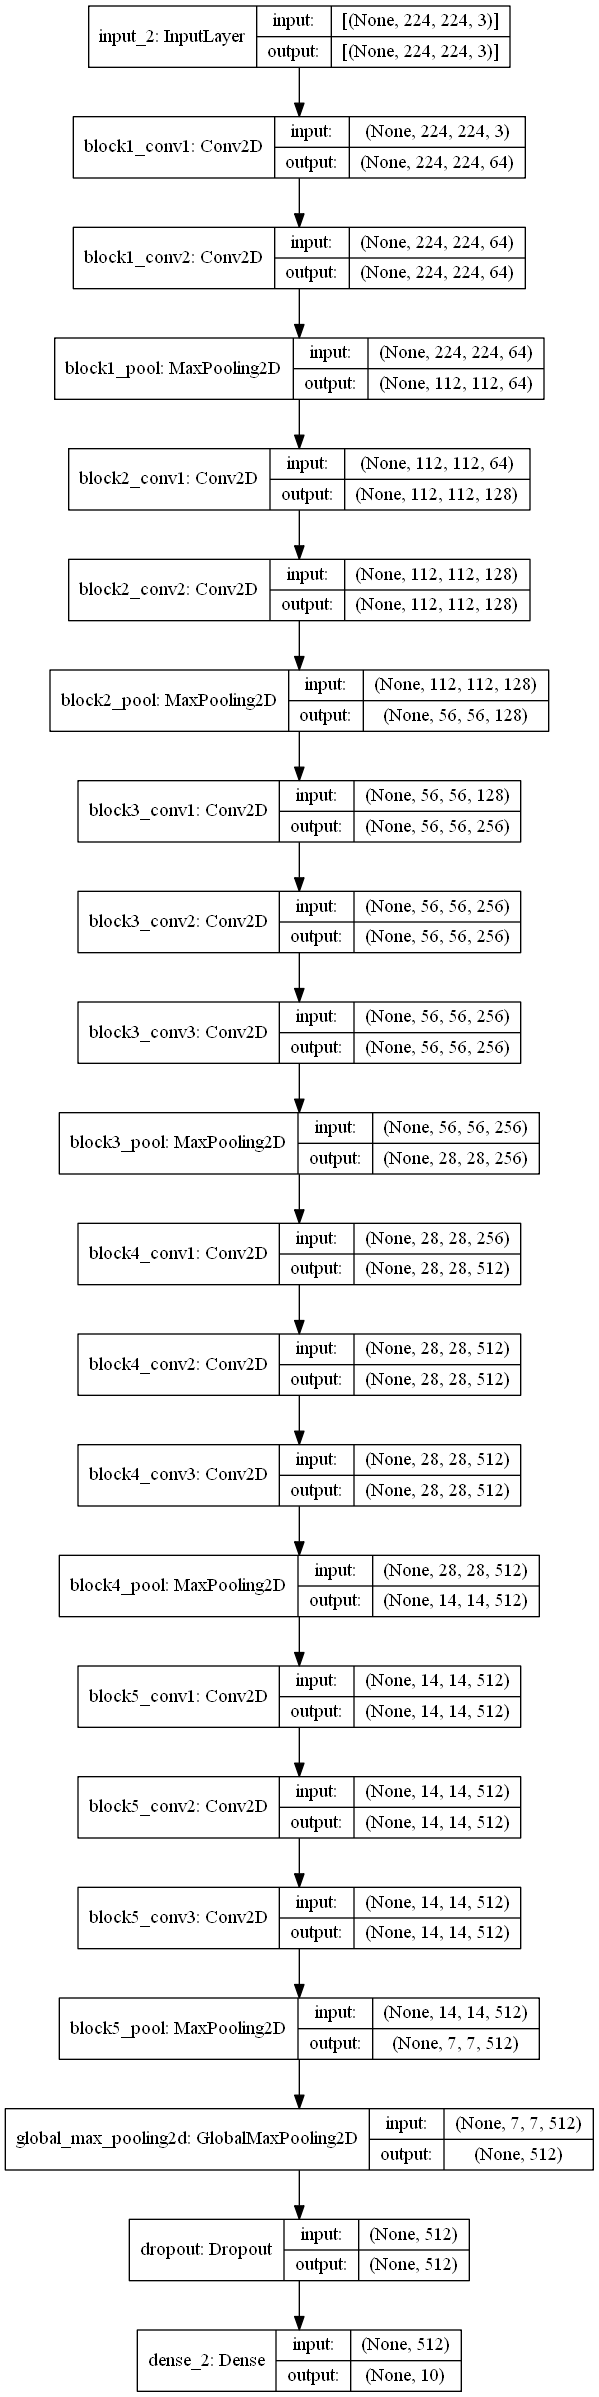

In [58]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Next, the ImageDataGenerator was utilized to prepare training, validation, and testing datasets directly from the images found in the appropriate directories. In our case, data augmentation worked to improve test set accuracy by roughly 3%. The details of the augmentation can be found in the cell below

In [59]:
batch_size = 32
training_generator = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 15,
        zoom_range = 0.15,
        width_shift_range = 0.12,
        height_shift_range = 0.12,
        horizontal_flip = False,
        vertical_flip = False,
        fill_mode = 'nearest'
        )

testing_generator =  ImageDataGenerator(
    rescale = 1./255)

Generate training data

In [60]:
print('Training: ')
training_data = training_generator.flow_from_directory(
train_data,
target_size = (224, 224),
batch_size = batch_size,  
class_mode = "categorical")

Training: 
Found 3498 images belonging to 10 classes.


Generate validation data

In [61]:
print('Validation:')
validation_data = testing_generator.flow_from_directory(
val_data,
target_size = (224, 224),
batch_size = batch_size,
class_mode = "categorical",
shuffle = False)

Validation:
Found 999 images belonging to 10 classes.


Generate testing data

In [62]:
print('Testing:')
testing_data = testing_generator.flow_from_directory(
test_data,
target_size = (224, 224),
batch_size = batch_size,
class_mode = "categorical",
shuffle = False)

Testing:
Found 501 images belonging to 10 classes.


Set the learning rate and number of epochs. We experimented with many learning rates, and found that 0.0001 resulted in the best performance. This learning rate balanced relatively quick learning with minimal overfitting, and was thus chosen for the final run. We also found that 20 epochs was more than enough to reach peak validation accuracy. In many cases, the early stopping callback preemptively stopped the training process, as validation accuracy was no longer increasing

In [15]:
learning_rate = 0.0001
epochs = 20

Next, the model checkpoint callback is instantiated to monitor validation accuracy, and save the model after each epoch that results in an increase in validation accuracy. This allows for restoring the optimal weights in the case of a drop in performance after some number of epochs

In [16]:
checkpoint = ModelCheckpoint("improved.h5", monitor = 'val_acc', verbose=1, save_best_only = True, save_weights_only = False, mode = 'auto', period = 1)

Next, the model was compiled with categorical cross entropy loss (standard for multi-class classification), and Adam as the optimizer. We chose Adam after performing several test runs with SGD and RMSprop, both of which resulted in worse performance. 

In [17]:
optimizer = Adam(lr = learning_rate, clipnorm = 1.0)
model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ['acc'])

As an additional safeguard against overfitting, the EarlyStopping callback was used to stop the training process if validation accuracy does not improve for five epochs, and restore the best weights

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True)

Next, the model was trained on our data, and saved with every epoch that yielded an increase in validation accuracy

In [19]:
history = model.fit(training_data, 
                              epochs = epochs, 
                              shuffle = True, 
                              validation_data = validation_data,
                              callbacks = [checkpoint, earlystop]
                              )

Epoch 1/20
110/110 [==============================] - 1656s 15s/step - loss: 1.9127 - acc: 0.2984 - val_loss: 1.5035 - val_acc: 0.4364

Epoch 00001: val_acc improved from -inf to 0.43644, saving model to improved.h5
Epoch 2/20
110/110 [==============================] - 1672s 15s/step - loss: 1.2376 - acc: 0.5670 - val_loss: 1.0705 - val_acc: 0.6106

Epoch 00002: val_acc improved from 0.43644 to 0.61061, saving model to improved.h5
Epoch 3/20
110/110 [==============================] - 1684s 15s/step - loss: 1.0711 - acc: 0.6122 - val_loss: 1.0383 - val_acc: 0.6356

Epoch 00003: val_acc improved from 0.61061 to 0.63564, saving model to improved.h5
Epoch 4/20
110/110 [==============================] - 1635s 15s/step - loss: 0.9289 - acc: 0.6531 - val_loss: 0.8158 - val_acc: 0.7057

Epoch 00004: val_acc improved from 0.63564 to 0.70571, saving model to improved.h5
Epoch 5/20
110/110 [==============================] - 1664s 15s/step - loss: 0.8155 - acc: 0.7074 - val_loss: 0.8510 - val_acc:

In the cells below, training accuracy was plotted against validation accuracy, and training loss was plotted against validation loss

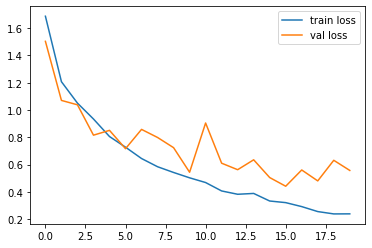

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

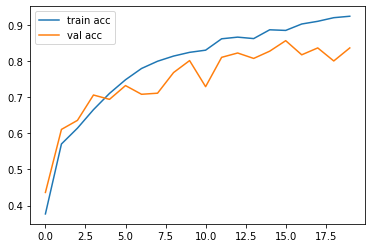

<Figure size 432x288 with 0 Axes>

In [21]:
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

The best model is loaded for prediction purposes

In [63]:
model = models.load_model("improved.h5")

The testing accuracy is computed by running the prediction function to obtain a probability vector, and choosing the maximum probability as the most likely label. The accuracy score is computed via a scikit-learn function, which divides the total number of correct predictions by the total number of predictions. The score was then converted to a percentage

In [66]:
Y_pred = model.predict(testing_data)
y_pred = np.argmax(Y_pred, axis=1)
accuracy = accuracy_score(testing_data.classes, y_pred)
print("Accuracy on test set: ")
print(accuracy)

Accuracy on test set: 
0.8582834331337326


The cell below prints out a simple, unlabeled confusion matrix. This was used primarily as a debugging tool, but also constitutes a useful visualization.

In [67]:
conf = confusion_matrix(testing_data.classes, y_pred)
print(conf)

[[46  2  1  0  0  0  0  1  0  0]
 [ 0 47  0  0  0  0  3  0  0  0]
 [ 1  0 44  0  0  2  2  0  1  0]
 [ 1  1  0 43  2  2  2  0  0  0]
 [ 0  1  0  2 40  0  1  6  0  0]
 [ 1  0  1  2  0 44  1  1  0  0]
 [ 0  8  1  2  0  1 38  0  0  0]
 [ 1  0  3  0  0  0  2 44  0  0]
 [ 0  1  2  0  0  0  0  0 44  3]
 [ 0  2  0  2  1  0  0  0  5 40]]


We also plotted the confusion matrix properly to produce a more robust visualization tool (this code was adapted from scikit-learn's implementation of the confusion matrix plot)

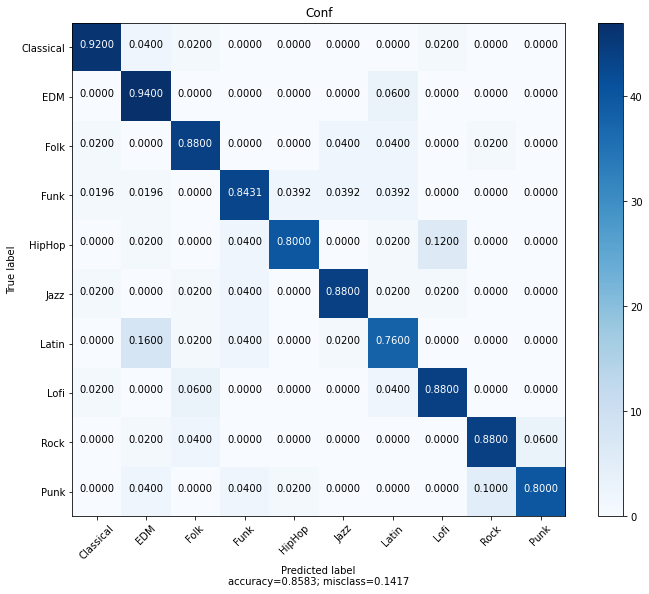

In [68]:
labels = ['Classical',
 'EDM',
 'Folk',
 'Funk',
 'HipHop',
 'Jazz',
 'Latin',
 'Lofi',
 'Rock',
 'Punk']

cm = confusion_matrix(testing_data.classes, y_pred)
accuracy = np.trace(cm) / np.sum(cm).astype('float')
misclass = 1 - accuracy

cmap = plt.get_cmap('Blues')

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title("Conf")
plt.colorbar()

ticks = np.arange(10)
plt.xticks(ticks, labels, rotation = 45)
plt.yticks(ticks, labels)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

threshold = cm.max() / 1.5 
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.show()

In [69]:
rep = classification_report(y_pred, testing_data.classes, target_names = classes)
print(rep)

              precision    recall  f1-score   support

   Classical       0.92      0.92      0.92        50
         EDM       0.94      0.76      0.84        62
        Folk       0.88      0.85      0.86        52
        Funk       0.84      0.84      0.84        51
      HipHop       0.80      0.93      0.86        43
        Jazz       0.88      0.90      0.89        49
       Latin       0.76      0.78      0.77        49
        Lofi       0.88      0.85      0.86        52
        Punk       0.88      0.88      0.88        50
        Rock       0.80      0.93      0.86        43

    accuracy                           0.86       501
   macro avg       0.86      0.86      0.86       501
weighted avg       0.86      0.86      0.86       501



As an additional interactive visualization, a chord graph is produced to examine the relationships between the classes that got misclassified

In [70]:
matrix = [[46,  2,  1,  0,  0,  0,  0,  1,  0,  0],
 [ 0, 47,  0,  0,  0,  0,  3,  0,  0,  0],
 [ 1,  0, 44,  0,  0,  2,  2,  0,  1,  0],
 [ 1,  1,  0, 43,  2,  2,  2,  0,  0,  0],
 [ 0,  1,  0,  2, 40,  0,  1,  6,  0,  0],
 [ 1,  0,  1,  2,  0, 44,  1,  1,  0,  0],
 [ 0,  8,  1,  2,  0,  1, 38,  0,  0,  0],
 [ 1,  0,  3,  0,  0,  0,  2, 44,  0,  0],
 [ 0,  1,  2,  0,  0,  0,  0,  0, 44,  3],
 [ 0,  2,  0,  2,  1,  0,  0,  0,  5, 40],]

names = ['Classical',
 'EDM',
 'Folk',
 'Funk',
 'HipHop',
 'Jazz',
 'Latin',
 'LoFi',
 'Punk',
 'Rock']

colors = ['#FF6103', '#7FFF00', '#3D59AB', '#DC143C', '#00EEEE', '#9932CC', '#FFD700', '#080808', '#00FF00', '#800000']

Chord(matrix, names, colors).to_html()
IFrame(src="./out.html", width=700, height=700)

Now, we will run a sample prediction on an entire song. The song is turned into a spectogram and sliced into 30 second pieces. Afterwards, each slice is independently classified, and the mode (most common slice label) is used to decide the final label for the entire song. 

In [71]:
from statistics import mode

In [72]:
# Delete all spectrograms in the test_song_imgs folder which is meant to contain spectrograms of only one song

for subdir, dirs, files in os.walk('test_song_imgs'):
    for file in files:
        img_file = subdir + '/' + file
        os.remove(img_file)

In [73]:
song_title = "Best of You - Foo Fighters.wav"

%run spec_creator "Best of You - Foo Fighters.wav"

#Change both of these to your desired audio file (in .wav format)

Spectrogram Creation Complete!




<Figure size 432x288 with 0 Axes>

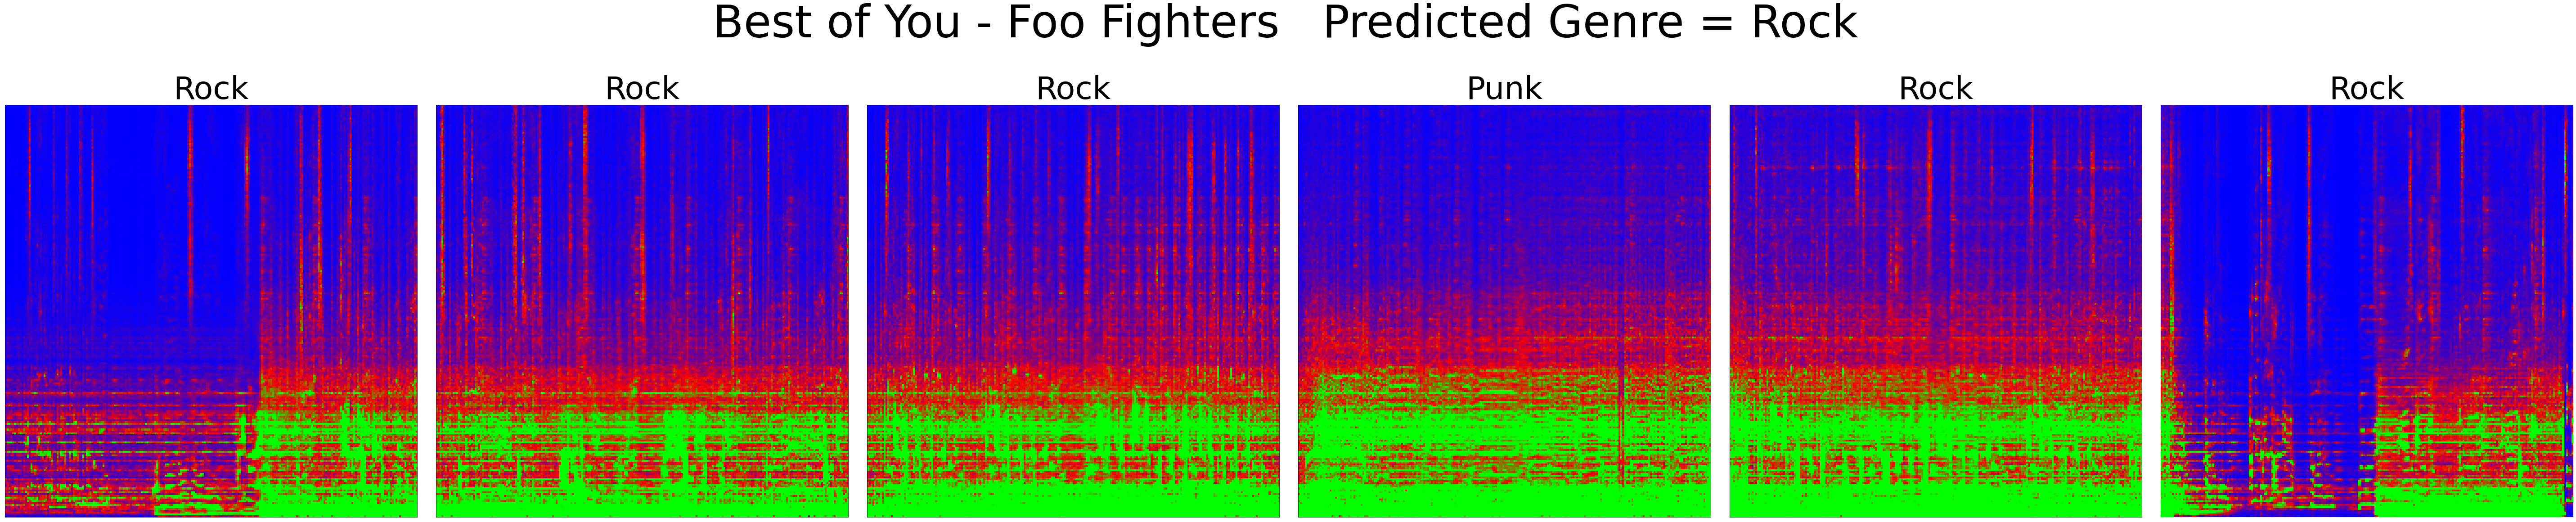

In [74]:
test_song_pred = []


for subdir, dirs, files in os.walk('test_song_imgs'):
    fig, axs = plt.subplots(1, len(files))
    fig.set_figheight(20)
    fig.set_figwidth(80)
    fig.tight_layout()
    #fig.axes.get_xaxis().set_visible(False)
    #fig.axes.get_yaxis().set_visible(False)
    axis = 0
    
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file)
        image = np.array(image)
        reshaped_image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        single_prediction = model.predict(reshaped_image)
        pred_genre = names[np.argmax(single_prediction)]
        test_song_pred.append(np.argmax(single_prediction))
        
        
        plt.axis("off")
        axs[axis].get_xaxis().set_visible(False)
        axs[axis].get_yaxis().set_visible(False)
        axs[axis].imshow(image)
        axs[axis].set_title(pred_genre, fontsize=70)
        axis += 1
    
    
    song_title = song_title.split(".")[0]
    
    master_genre = names[mode(test_song_pred)]
    
    master_title = str(song_title + "   Predicted Genre = " + str(master_genre))
    fig.suptitle(master_title, fontsize = 100)